In [1]:
# install yolov8 
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.9/608.9 kB 20.9 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO
import os
import random
import shutil
import numpy as np
import pandas as pd
import cv2
import yaml
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# setting parameters

In [3]:
DIR = "/kaggle/working/datasets/cars/"
IMAGES = DIR +"images/"
LABELS = DIR +"labels/"

TRAIN = "/kaggle/input/car-object-detection/data/training_images"
TEST = "/kaggle/input/car-object-detection/data/testing_images"

In [4]:
df = pd.read_csv("/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv")
df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


# setting dataset

In [5]:
files = list(df.image.unique())

files_train, files_valid = train_test_split(files, test_size = 0.2)

In [6]:
# !rm -r /kaggle/working/dataset

In [7]:
# make directories
os.makedirs(IMAGES+"train", exist_ok=True)
os.makedirs(LABELS+"train", exist_ok=True)
os.makedirs(IMAGES+"valid", exist_ok=True)
os.makedirs(LABELS+"valid", exist_ok=True)

In [8]:
train_filename = set(files_train)
valid_filename = set(files_valid)
for file in glob.glob(TRAIN+"/*"):
    fname =os.path.basename(file)
    if fname in train_filename:
        shutil.copy(file, IMAGES+"train")
    elif fname in valid_filename:
        shutil.copy(file, IMAGES+"valid")

In [9]:
for _, row in df.iterrows():    
    image_file = row['image']
    class_id = "0"
    x = row['xmin']
    y = row['ymin']
    width = row['xmax'] - row['xmin']
    height = row['ymax'] - row['ymin']

    x_center = x + (width / 2)
    y_center = y + (height / 2)
    x_center /= 676
    y_center /= 380
    width /= 676
    height /= 380

    if image_file in train_filename:   
        annotation_file = os.path.join(LABELS) + "train/" + image_file.replace('.jpg', '.txt')
    else:
        annotation_file = os.path.join(LABELS) + "valid/" + image_file.replace('.jpg', '.txt')
        
    with open(annotation_file, 'a') as ann_file:
        ann_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

# setup yaml file

In [10]:
%%writefile dataset.yaml
# Path
path: ./cars
train: images/train
val: images/valid

# Classes
nc: 1
names: ['car']

Writing dataset.yaml


# disable wandb

In [11]:
# disable wandb
import wandb
wandb.init(mode="disabled")

# Train

In [12]:
model = YOLO('yolov8n.pt')
model.train(data="dataset.yaml", epochs=100, batch=8)

100%|██████████| 6.23M/6.23M [00:00<00:00, 21.6MB/s]
Ultralytics YOLOv8.0.164 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=100, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes

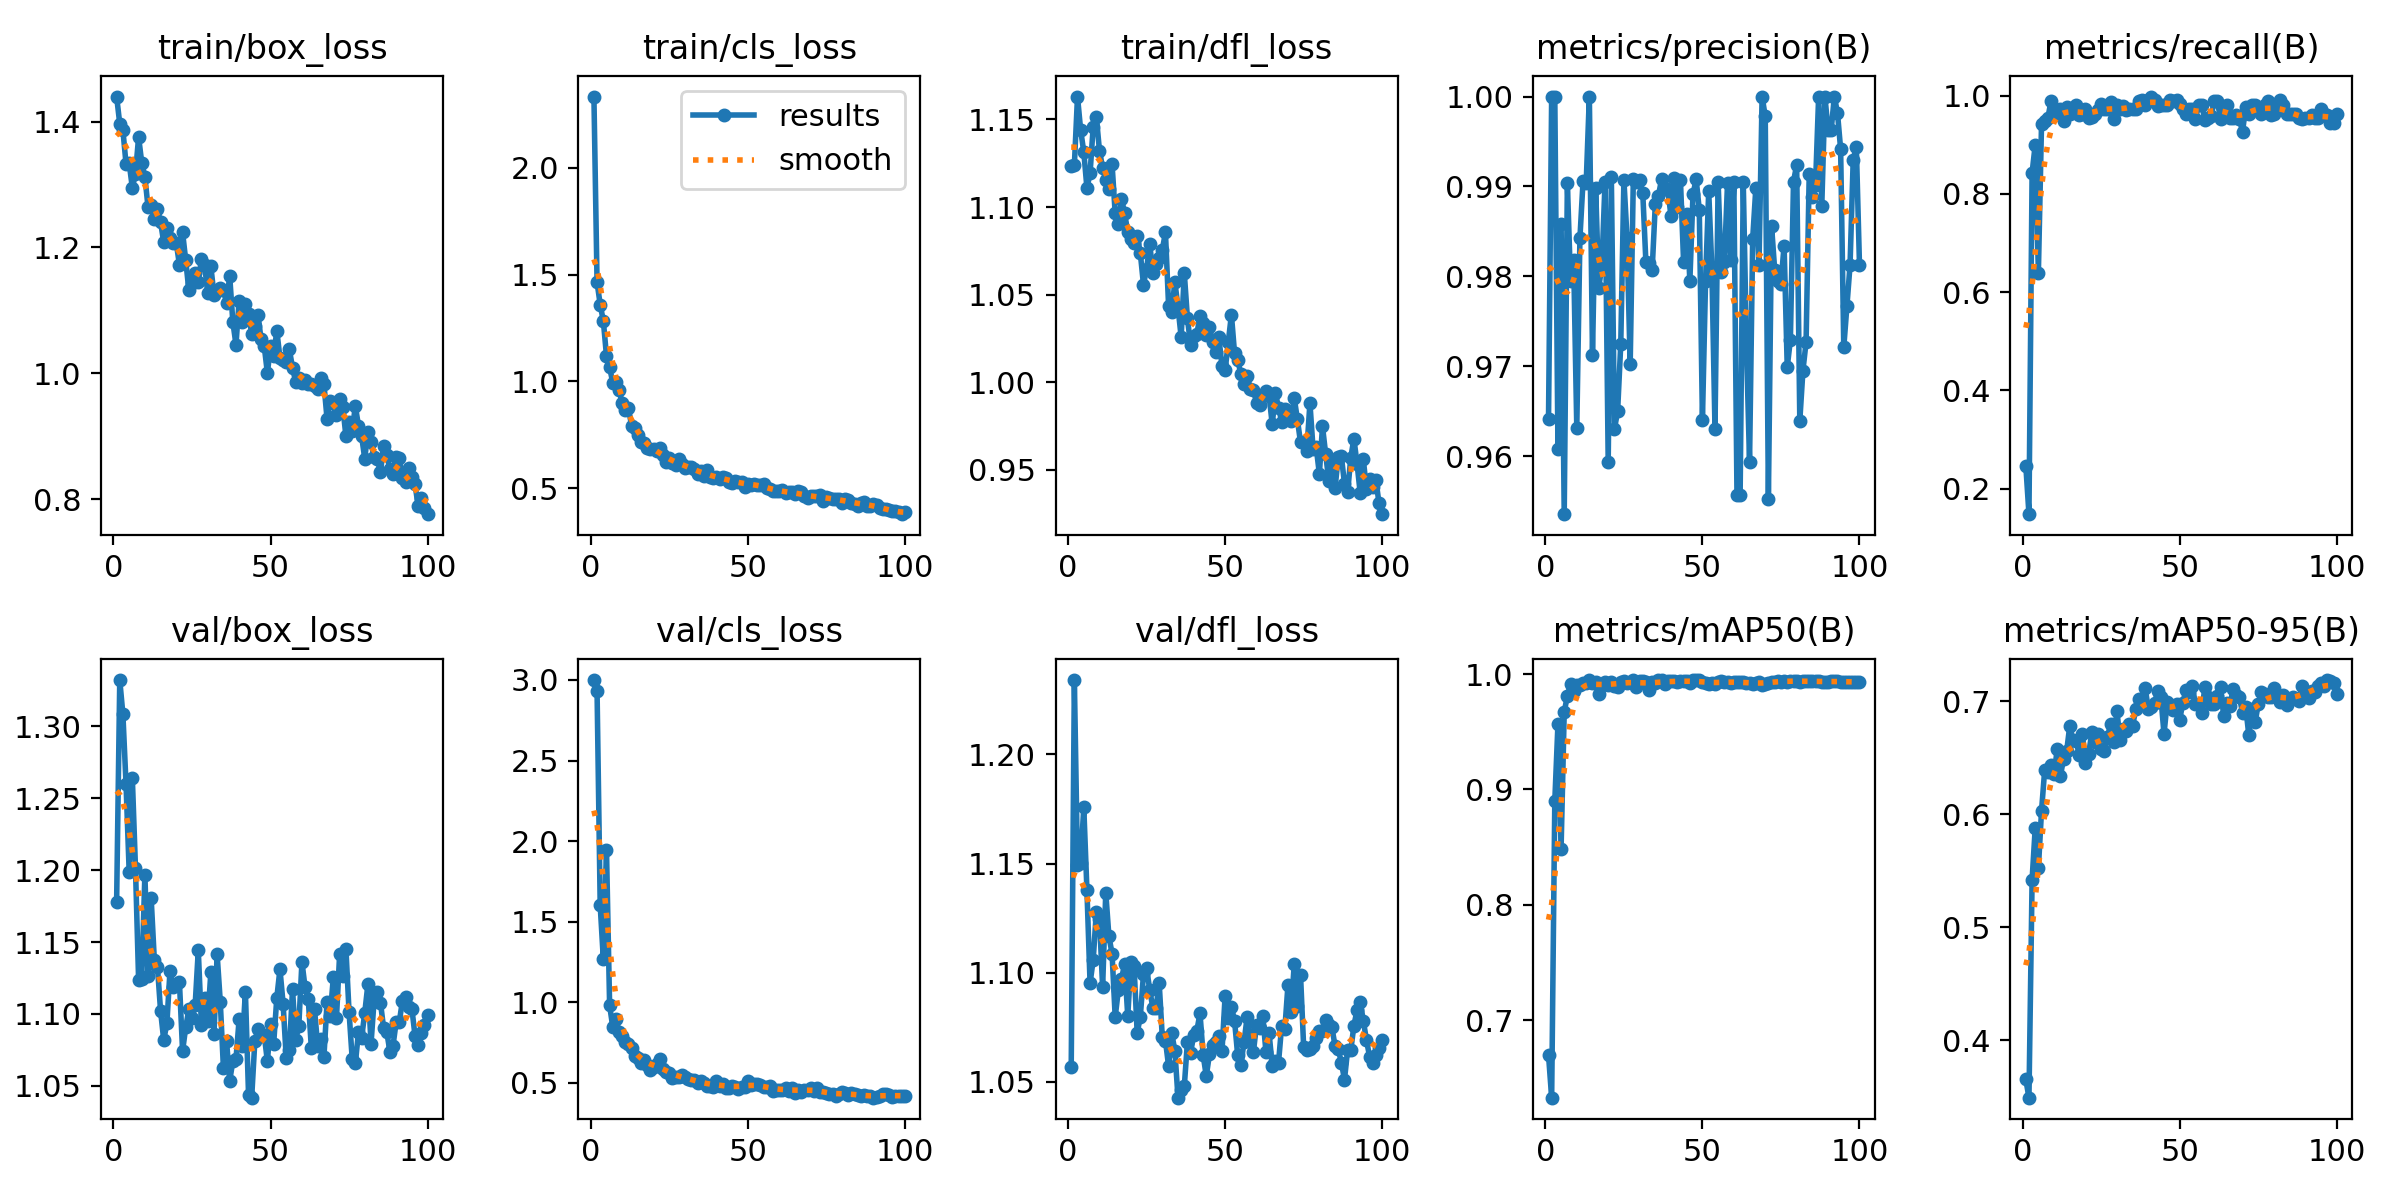

In [13]:
from IPython.display import Image

Image("/kaggle/working/runs/detect/train/results.png")

# inference (test)

In [14]:
model = YOLO('./runs/detect/train/weights/last.pt')
ret = model("/kaggle/input/car-object-detection/data/testing_images",save=True, conf=0.2, iou=0.5)


image 1/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 58.1ms
image 2/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 6.6ms
image 3/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 6.2ms
image 4/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 6.5ms
image 5/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 6.4ms
image 6/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 6.7ms
image 7/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 6.2ms
image 8/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 6.2ms
image 9/175 /kaggle/input/car-object-detection/data/testing_images/vid_5_25260

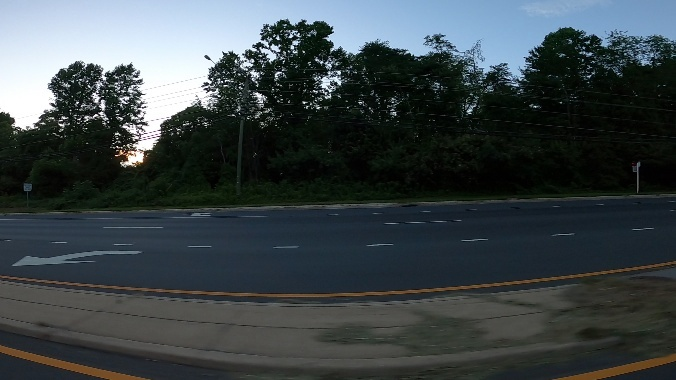

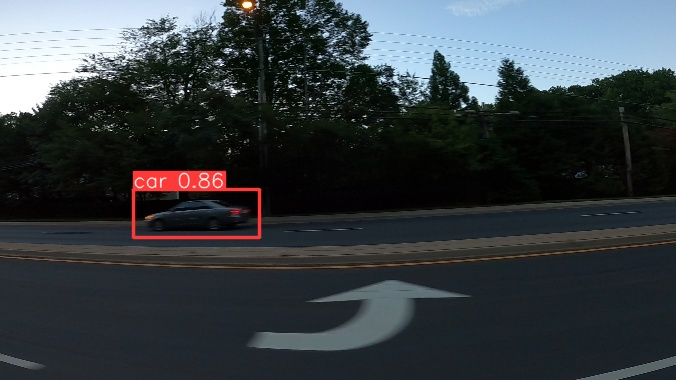

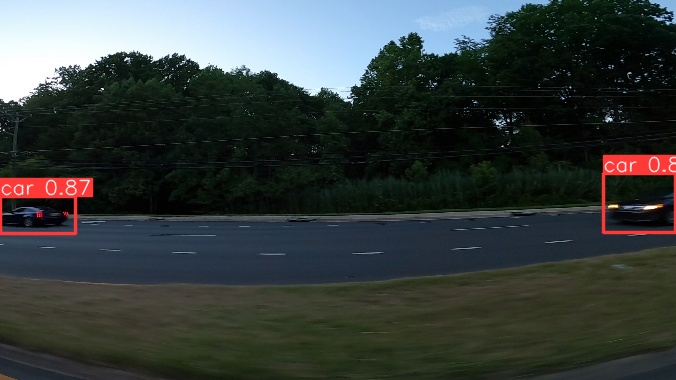

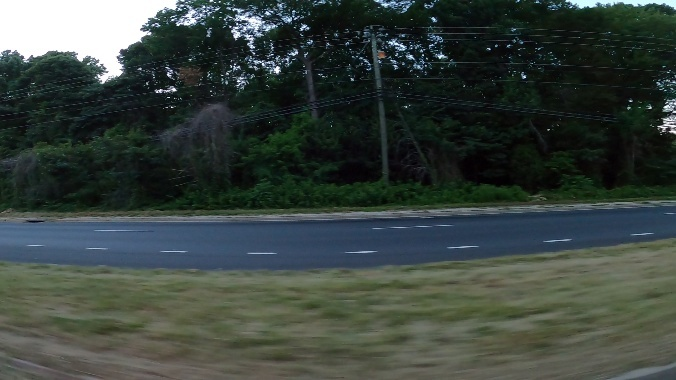

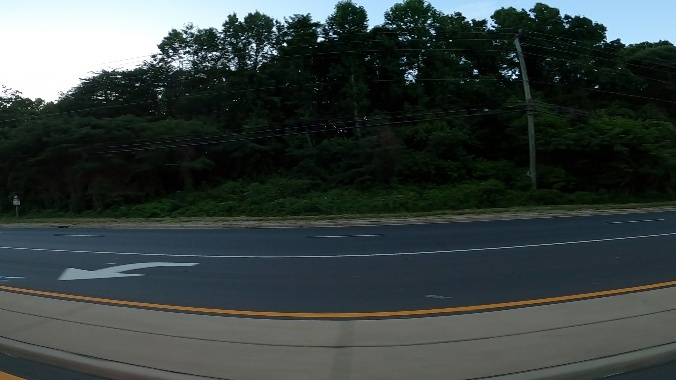

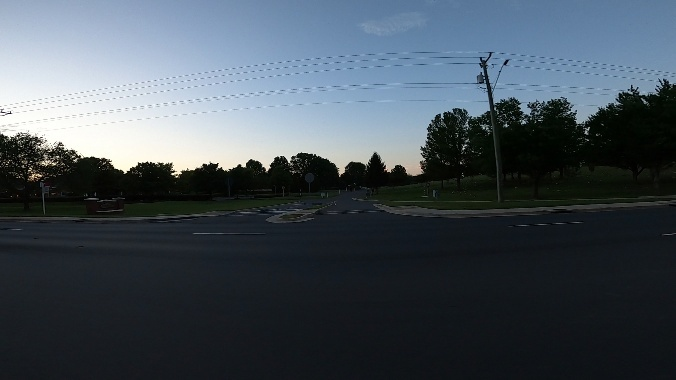

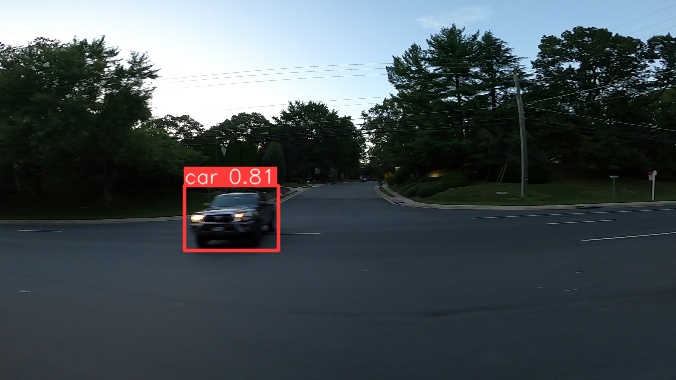

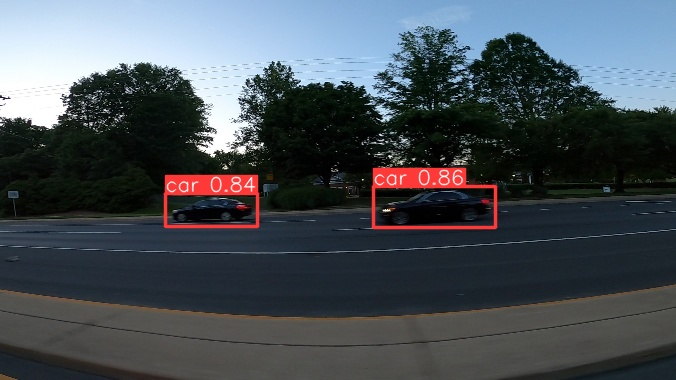

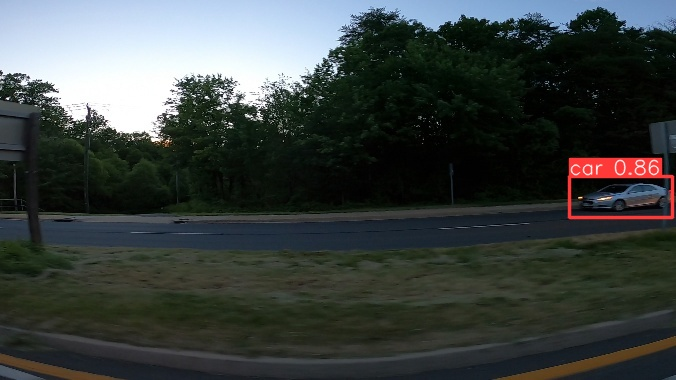

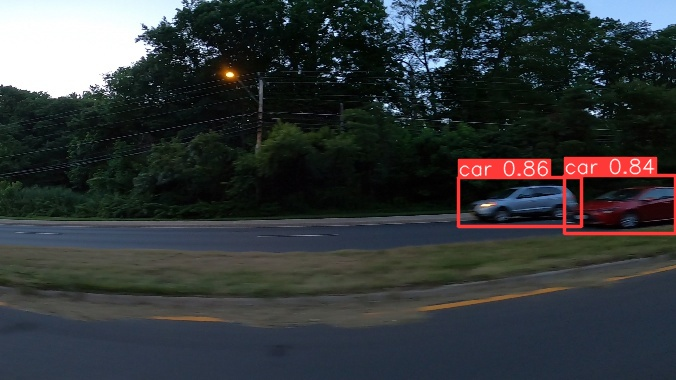

In [15]:
# display result
files = glob.glob("./runs/detect/predict/*")
for i in range(0, 30, 3):
    img = Image(files[i])
    display(img)